<a href="https://colab.research.google.com/github/supskv/ml-sugarcane-project/blob/master/ML_project_ex2_conv1d_%3Elstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from copy import copy
import torch
import matplotlib.pyplot as plt

from google.colab import drive
from IPython.display import clear_output

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dataset_path = '/content/drive/MyDrive/AIT/ML'

In [4]:
def file_to_data(filename):
    
    # read file
    raw = pd.read_csv(filename)
    
    # define columns to be extracted
    ndvi_col = ['ndvi_mean'+str(i) for i in range(1, 24+1)] # ndvi_mean1, ..., ndvi_mean24
    savi_col = ['ndvi_mean'+str(i) for i in range(1, 24+1)] # ndvi_mean1, ..., savi_mean24
    evi_col = ['ndvi_mean'+str(i) for i in range(1, 24+1)] # ndvi_mean1, ..., evi_mean24

    # extract each feature
    ndvi_timeseries = raw[ndvi_col]
    savi_timeseries = raw[savi_col]
    evi_timeseries = raw[evi_col]
    
    # dimension stack
    data = np.dstack([ndvi_timeseries, savi_timeseries, evi_timeseries])
    
    # get only label
    label = raw.iloc[:, -1]
    
    return data, label

def data_to_lv1_x_y(data, labels):
    
    # export all X
    # but reclass the plant cane -> 100, ratoon cane -> 200
    target = copy(labels)
    target[target > 200] = 200
    target[(target < 200) & (target > 100)] = 100
    
    return data, target

def data_to_lv2_x_y(data, target):
    
    # export X plant which labels are 100-200
    X_plant = data[(target > 100) & (target <200)]
    
    # export X ratoon which labels are >200
    X_ratoon = data[target > 200]
    
    # export y plant which labels are 100-200
    y_plant = target[(target > 100) & (target < 200)]
    
    # export y ratoon which labels are >200
    y_ratoon = target[target > 200]
    
    return X_plant, y_plant, X_ratoon, y_ratoon

def label_encode(y):
    
    target = copy(y)
    # redefine the cane plantation label to be 1 - 24
    new_y = [int(str(label)[1:]) for label in target]
    
    return np.array(new_y)

In [5]:
data_train, labels_train = file_to_data('/content/drive/MyDrive/AIT/ML/training_data_1718.csv')
data_test, labels_test = file_to_data('/content/drive/MyDrive/AIT/ML/training_data_1819.csv')

In [11]:
X_plant_train, y_plant_train, X_ratoon_train, y_ratoon_train = data_to_lv2_x_y(data_train, labels_train)
X_plant_test, y_plant_test, X_ratoon_test, y_ratoon_test = data_to_lv2_x_y(data_test, labels_test)

In [12]:
def makelabel(y):
  y = y.to_numpy()
  for i in range(len(y)):
    if y[i] %100 >0 and y[i] %100<=4:
      y[i] = 0 
    elif y[i] %100>4 and y[i] %100<=8:
      y[i] = 1 
    elif y[i]%100>8 :
      y[i] = 2 
  return y
y_plant_train = makelabel(y_plant_train)
y_ratoon_train = makelabel(y_ratoon_train)

y_plant_test = makelabel(y_plant_test)
y_ratoon_test = makelabel(y_ratoon_test)

In [13]:
print(f'numeric class of y train: {np.unique(y_plant_train)}')
print(f'numeric class of y test: {np.unique(y_plant_test)}')

numeric class of y train: [0 1 2]
numeric class of y test: [0 1 2]


In [15]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [16]:
shape_plant = X_plant_train.shape
shape_ratoon = X_ratoon_train.shape
print(Counter(y_plant_train))
print(Counter(y_ratoon_train))

Counter({0: 2392, 1: 1912, 2: 185})
Counter({1: 4395, 0: 3467, 2: 16})


In [17]:
X_plant_train = X_plant_train.reshape(X_plant_train.shape[0], -1)
X_ratoon_train = X_ratoon_train.reshape(X_ratoon_train.shape[0], -1)
print(f'X plant train: {X_plant_train.shape}')
print(f'X ratoon train: {X_ratoon_train.shape}')

X plant train: (4489, 72)
X ratoon train: (7878, 72)


In [18]:
# instantiating the random over sampler 
ros = RandomOverSampler()
# resampling X, y
X_plant_train, y_plant_train = ros.fit_resample(X_plant_train, y_plant_train)
X_ratoon_train, y_ratoon_train = ros.fit_resample(X_ratoon_train, y_ratoon_train)

print(f'after oversampled-> X plant shape: {X_plant_train.shape}')
print(f'after oversampled-> X ratoon shape: {X_ratoon_train.shape}')

after oversampled-> X plant shape: (7176, 72)
after oversampled-> X ratoon shape: (13185, 72)


In [19]:
X_plant_train = X_plant_train.reshape(X_plant_train.shape[0], 24,3)
X_ratoon_train = X_ratoon_train.reshape(X_ratoon_train.shape[0], 24,3)

print(f'X plant train: {X_plant_train.shape}')
print(f'X ratoon train: {X_ratoon_train.shape}')

X plant train: (7176, 24, 3)
X ratoon train: (13185, 24, 3)


In [20]:
print(Counter(y_plant_train))
print(Counter(y_ratoon_train))

Counter({0: 2392, 1: 2392, 2: 2392})
Counter({0: 4395, 1: 4395, 2: 4395})


In [21]:
"""X_plant_train = X_plant_train.transpose(0,2,1)[:, np.newaxis,:,:]
X_ratoon_train = X_ratoon_train.transpose(0,2,1)[:, np.newaxis,:,:]"""

X_plant_train = X_plant_train.transpose(0,2,1)[:,:,:18]
X_ratoon_train = X_ratoon_train.transpose(0,2,1)[:,:,:18]

In [22]:
print(f'X plant train: {X_plant_train.shape}')
print(f'X ratoon train: {X_ratoon_train.shape}')

X plant train: (7176, 3, 18)
X ratoon train: (13185, 3, 18)


In [23]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split

def Xy_dataloader(X_numpy, y_numpy, batch_size=32):
    
    X_tensor = torch.tensor(X_numpy).float()
    y_tensor = torch.tensor(y_numpy).long()
    
    dataset = TensorDataset(X_tensor, y_tensor)

    loader = DataLoader(dataset, batch_size=batch_size,shuffle=True)
    
    return loader

In [51]:
from sklearn.model_selection import train_test_split

X_plant_train, X_plant_valid, y_plant_train, y_plant_valid = train_test_split(X_plant_train, y_plant_train  , test_size=0.3, stratify=y_plant_train)


In [52]:
X_ratoon_train, X_ratoon_valid, y_ratoon_train, y_ratoon_valid = train_test_split(X_ratoon_train, y_ratoon_train, test_size=0.3, stratify=y_ratoon_train)

In [78]:
xtrain_mix = np.concatenate((X_plant_train, X_ratoon_train), axis=0)
ytrain_mix = np.concatenate((y_plant_train, y_ratoon_train), axis=0)

xvali_mix = np.concatenate((X_plant_valid, X_ratoon_valid), axis=0)
yvali_mix = np.concatenate((y_plant_valid, y_ratoon_valid), axis=0)

train_loader = Xy_dataloader(xtrain_mix, ytrain_mix, 256)
valid_loader = Xy_dataloader(xvali_mix, yvali_mix, 256)


# original

In [ ]:
import torch
from torch import nn

In [ ]:

class RNN_lv1(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        
        self.rnn = nn.LSTM(input_dim, hidden_dim, num_layers=1, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
     
        
        #[batch size, seq len, embed dim]
        out, (hn, cn) = self.rnn(x)
        x = self.dropout(hn.squeeze(0))
        x = self.fc(x)
        
        return x

In [ ]:

class CNN_lv2(nn.Module):
    
    def __init__(self, output_dim):
        super().__init__()
        
        self.conv1 = nn.Sequential(nn.Conv2d(1, 16, (1,3), stride=1, padding='valid'),
                                  nn.BatchNorm2d(16),
                                  nn.ReLU())
        
        self.conv2 = nn.Sequential(nn.Conv2d(16, 32, (1,3), stride=1, padding='valid'),
                                  nn.BatchNorm2d(32),
                                  nn.ReLU(),
                                  nn.MaxPool2d(2,2))
        
        
        self.dropout = nn.Dropout(0.5)


        self.fc1 = nn.Linear(32*1*10, 1024)
        self.fc2 = nn.Linear(1024, output_dim)
        
    def forward(self, x):
     
        
        #[batch size, seq len, embed dim]
        x = self.conv1(x)
        x = self.dropout(x)
        x = self.conv2(x)
        x = self.dropout(x)
        # print(x.shape)
        x = x.reshape(x.size(0),-1)
        x = self.fc1(x)
        x = self.fc2(x)

        
        return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda


In [ ]:
model_plant = RNN_lv1(3, 512, 24).to(device)
model_ratoon = RNN_lv1(3, 512, 24).to(device)

In [ ]:
model_plant = CNN_lv2(24).to(device)
model_ratoon = CNN_lv2(24).to(device)

In [ ]:
import torch.optim as optim

optimizer_plant = optim.Adam(model_plant.parameters(), lr=0.001) #<----changed to Adam
criterion_plant = nn.CrossEntropyLoss() #combine sigmoid with binary cross entropy

optimizer_ratoon = optim.Adam(model_ratoon.parameters(), lr=0.001) #<----changed to Adam
criterion_ratoon = nn.CrossEntropyLoss() #combine sigmoid with binary cross entropy

In [ ]:
def train_model(model, train_dataloader, valid_dataloader, 
                epochs, criterion, optimizer, print_epoch=1000):
    
    loss_train = []
    loss_valid = []
    acc_train = []
    acc_valid = []
    
    for i in range(1, epochs+1):
        
        # ===================TRAIN ======================
        model.train()
        
        epoch_loss = 0
        correct = 0
        
        for x, y in train_dataloader:
            
            x = x.to(device)
            y = y.to(device)
            
            out = model(x)
            
            loss = criterion(out, y)
            
            _,pred = torch.max(out, 1)
            
            correct += (pred == y).to('cpu').float().sum()
            
            epoch_loss += loss.item()
            
            #backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        acc_train.append(100 * correct / len(train_dataloader.dataset))
        loss_train.append(epoch_loss/len(train_dataloader))
        # loss_train.append(epoch_loss)
        
        # ===================VALIDATION =================
        model.eval()
    
        epoch_loss = 0
        correct = 0
        
        for x, y in valid_dataloader:
            
            x = x.to(device)
            y = y.to(device)
            
            out = model(x)
            
            loss = criterion(out, y)
            
            _,pred = torch.max(out, 1)
            
            correct += (pred == y).to('cpu').float().sum()
            
            epoch_loss += loss.item()
        
        acc_valid.append(100 * correct / len(valid_dataloader.dataset))
        loss_valid.append(epoch_loss/len(valid_dataloader))
        # loss_valid.append(epoch_loss)
        
        # ================= PRINT ===========================
        if i % print_epoch == 0 :
            clear_output(wait=True)
            print(f'epoch {i}/{epochs} train loss: {np.round(loss_train[-1],5)} train acc: {np.round(acc_train[-1],5)} validation loss: {np.round(loss_valid[-1],5)} validation acc: {np.round(acc_valid[-1],5)}')
            plt.plot(loss_train, label='train')
            plt.plot(loss_valid, label='test')
            plt.title('Loss during Training')
            plt.xlabel('epoch')
            plt.ylabel('loss')
            plt.legend()
            plt.show()

            plt.plot(acc_train, label='train')
            plt.plot(acc_valid, label='test')
            plt.title('Accuracy during Training')
            plt.xlabel('epoch')
            plt.ylabel('accuracy')
            plt.legend()
            plt.show()    
            
    return model, loss_train, loss_valid, acc_train, acc_valid
            

epoch 200/200 train loss: 1.13984 train acc: 54.68901824951172 validation loss: 1.18687 validation acc: 52.806121826171875


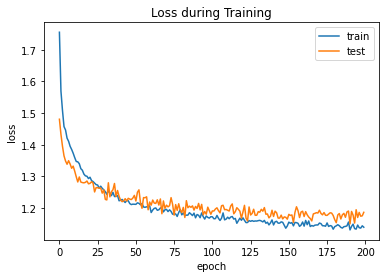

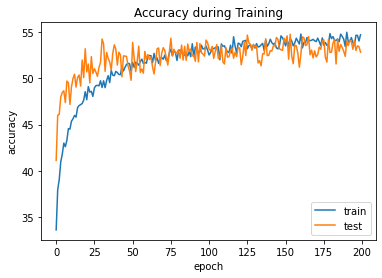

In [ ]:
model_plant, loss_train_plant, loss_valid_plant, acc_train_plant, acc_valid_plant = train_model(model_plant, plant_train_loader, plant_valid_loader, 200, criterion_plant, optimizer_plant, 1)

epoch 200/200 train loss: 1.17309 train acc: 50.0041618347168 validation loss: 1.16544 validation acc: 50.369361877441406


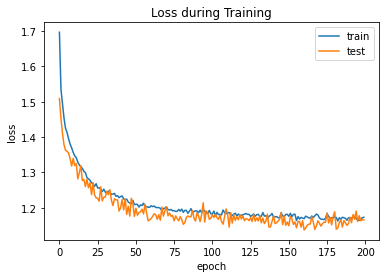

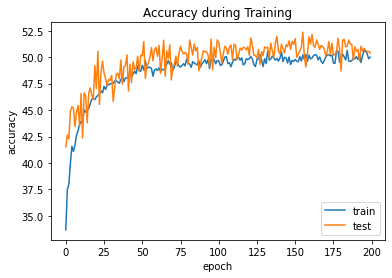

In [ ]:
model_ratoon, loss_train_ratoon, loss_valid_ratoon, acc_train_ratoon, acc_valid_ratoon = train_model(model_ratoon, ratoon_train_loader, ratoon_valid_loader, 200, criterion_ratoon, optimizer_ratoon, 1)

In [ ]:
def predict_model(model, X_test):
    
    model.eval()
    
    x = torch.tensor(X_test).float()
    
    x = x.to(device)
            
    out = model(x).to('cpu')
    
    pred = torch.max(out, 1)[1].numpy()
    
    return pred

In [ ]:
y_pred_plant = predict_model(model_plant, X_plant_valid)
y_pred_ratoon = predict_model(model_ratoon, X_ratoon_valid)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_ratoon_valid, y_pred_ratoon))
print(classification_report(y_plant_valid, y_pred_plant))

              precision    recall  f1-score   support

           0       0.52      0.75      0.61       571
           1       0.37      0.58      0.45       571
           2       0.42      0.35      0.38       572
           3       0.55      0.05      0.09       572
           4       0.34      0.32      0.33       571
           5       0.36      0.26      0.30       572
           6       0.67      0.24      0.35       571
           7       0.62      1.00      0.76       572
          23       0.70      1.00      0.82       572

    accuracy                           0.50      5144
   macro avg       0.50      0.50      0.45      5144
weighted avg       0.50      0.50      0.45      5144

              precision    recall  f1-score   support

           0       0.39      0.50      0.44       294
           1       0.33      0.49      0.39       294
           2       0.25      0.11      0.15       294
           3       0.21      0.17      0.19       294
           4       0.45 

In [ ]:
from sklearn.metrics import confusion_matrix

cf_matrix_plant = confusion_matrix(y_plant_valid, y_pred_plant)
cf_matrix_ratoon = confusion_matrix(y_ratoon_valid, y_pred_ratoon)

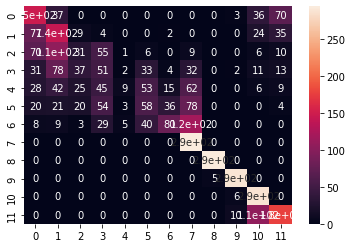

In [ ]:
import seaborn as sns
sns.heatmap(cf_matrix_plant, annot=True)


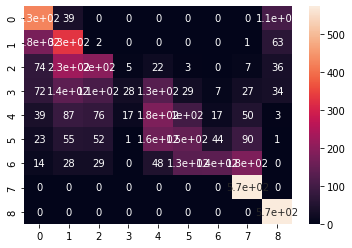

In [ ]:
sns.heatmap(cf_matrix_ratoon, annot=True)

In [ ]:
drive.flush_and_unmount()

# Conv1D -> LSTM

In [79]:
hidden_dim = 18
embed_dim = 8
output_dim = 3 #len(np.unique(y_plant_train))
num_layers = 1
bidirectional = True
dropout = 0.5

num_epochs = 500
lr = 0.0001

In [80]:
import torch
from torch import nn
class con1dlstm(nn.Module):
    def __init__(self):
        super().__init__()
               
        self.layer1 = nn.Sequential(
            nn.Conv1d(3, 9, 3, stride=2),
            nn.ReLU(),
            nn.Dropout(p=0.1))      
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers,
                    bidirectional=bidirectional, 
                    dropout=dropout,
                    batch_first=True)
        self.fc = nn.Linear(hidden_dim*2, output_dim)   
    
    
    def forward(self, x):
        out0 = self.layer1(x)    
        out,(hn, cn) = self.lstm(out0)
        hn = torch.cat((hn[-2,:,:], hn[-1,:,:]), dim = 1)
        
        return self.fc(hn)

In [81]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.RNN):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.orthogonal_(param) #<---here

In [82]:
model = con1dlstm().float()
model.apply(initialize_weights)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


con1dlstm(
  (layer1): Sequential(
    (0): Conv1d(3, 9, kernel_size=(3,), stride=(2,))
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
  )
  (lstm): LSTM(8, 18, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=36, out_features=3, bias=True)
)

In [83]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=lr) #<----changed to Adam
#optimizer = optim.RMSprop(model.parameters(), lr=lr)

#criterion = nn.BCEWithLogitsLoss() #combine sigmoid with binary cross entropy
criterion = nn.CrossEntropyLoss()
#criterion = nn.MSELoss()

In [84]:
def cnn_acc(preds,y):
    _, predicted = torch.max(preds.data, 1)
    correct = (predicted == y).float().sum()
    acc = correct / y.size(0)
    return acc

In [85]:
def train(model, loader, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train() #useful for batchnorm and dropout
    for i, (features, label) in enumerate(loader): 
                
        #predict
        predictions = model(features)
        #calculate loss
        loss = criterion(predictions, label)
        acc = cnn_acc(predictions, label)
        
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
                
    return epoch_loss / len(loader), epoch_acc / len(loader)

In [86]:
def evaluate(model, loader, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for i, (features, label) in enumerate(loader): 


            predictions = model(features)
            
            loss = criterion(predictions, label)
            acc = cnn_acc(predictions, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(loader), epoch_acc / len(loader)

In [87]:
best_valid_loss = float('inf')

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []
for epoch in range(num_epochs):

    train_loss,train_acc = train(model, plant_train_loader, optimizer , criterion)
    valid_loss,valid_acc = evaluate(model, plant_valid_loader, criterion)
    
    #for plotting
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(),'tensor.pt')
    
    if epoch%50 == 0:
        print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Train Loss: 1.101 | Train Acc: 27.15%
	 Val. Loss: 1.098 |  Val. Acc: 27.13%
Epoch: 51 | Train Loss: 0.535 | Train Acc: 74.75%
	 Val. Loss: 0.507 |  Val. Acc: 76.52%
Epoch: 101 | Train Loss: 0.496 | Train Acc: 76.77%
	 Val. Loss: 0.478 |  Val. Acc: 77.91%
Epoch: 151 | Train Loss: 0.473 | Train Acc: 78.00%
	 Val. Loss: 0.464 |  Val. Acc: 77.84%
Epoch: 201 | Train Loss: 0.458 | Train Acc: 78.24%
	 Val. Loss: 0.453 |  Val. Acc: 78.33%
Epoch: 251 | Train Loss: 0.455 | Train Acc: 78.75%
	 Val. Loss: 0.448 |  Val. Acc: 79.63%
Epoch: 301 | Train Loss: 0.452 | Train Acc: 78.49%
	 Val. Loss: 0.443 |  Val. Acc: 79.38%
Epoch: 351 | Train Loss: 0.446 | Train Acc: 79.01%
	 Val. Loss: 0.441 |  Val. Acc: 79.57%
Epoch: 401 | Train Loss: 0.446 | Train Acc: 78.81%
	 Val. Loss: 0.446 |  Val. Acc: 79.10%
Epoch: 451 | Train Loss: 0.442 | Train Acc: 79.26%
	 Val. Loss: 0.439 |  Val. Acc: 79.82%


Text(0, 0.5, 'loss')

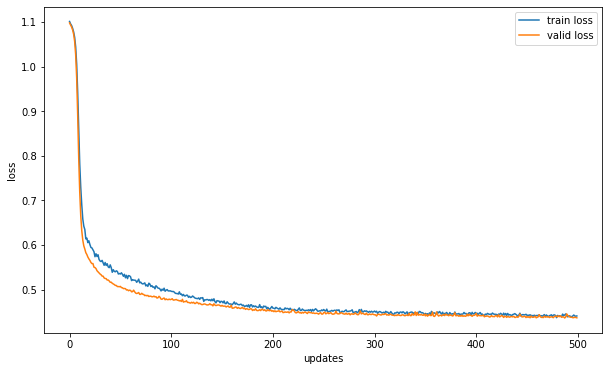

In [88]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

Text(0, 0.5, 'acc')

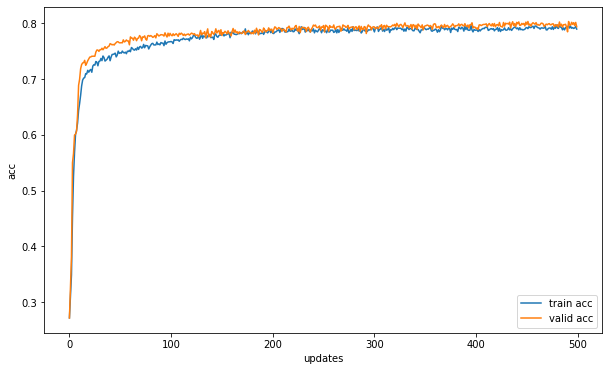

In [89]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_accs, label = 'train acc')
ax.plot(valid_accs, label = 'valid acc')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('acc')